# MELANOMA EFFICIENTNET-B7 WITH TPUS

* ME7-v1 epochs 15 
* ME7-v4 epochs 20 fold 1 ***(LB - 0.900)***
* ME7-v5 epochs 25 save best 3 fold 2 **(LB 0.886)**
* ME7-v7 fold3 **(LB 0.892)**
* ME7-v9 fold4 **(LB 0.899)** 
* ME7-v10 fold5 **(LB )**
* To do : augmentation and learning rates

In [1]:
colab=0
show_files=0
tstamp=0
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
if (not colab)&show_files:
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output

### Loading libraries

In [2]:
!pip install -q efficientnet

In [3]:
import math
import pytz
import random
import numpy as np
import pandas as pd
import math, re, os, gc
import tensorflow as tf
from pathlib import Path
from datetime import datetime
from scipy.stats import rankdata
import efficientnet.tfkeras as efn
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

if not colab:
    from kaggle_datasets import KaggleDatasets

Tensorflow version 2.2.0


In [4]:
if colab:
    PATH=Path('/content/gdrive/My Drive/kaggle/input/siim-isic-melanoma-classification/') 
    train=pd.read_csv(PATH/'train.csv.zip')
else:
    PATH=Path('/kaggle/input/siim-isic-melanoma-classification/')
    train=pd.read_csv(PATH/'train.csv')
test=pd.read_csv(PATH/'test.csv')
sub=pd.read_csv(PATH/'sample_submission.csv')

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
SEED=121
seed_everything(SEED)

## TPU INITIALIZATION

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
IMAGE_SIZE = [512, 512]
EPOCHS=25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
CLASSES = ['benign', 'malignant']
NAME='EffNB0_512'
NFOLDS=5
NBEST=3

In [7]:
if colab: 
    SAVE_FOLDER=NAME
    if tstamp:
        time_zone = pytz.timezone('America/Chicago')
        current_datetime = datetime.now(time_zone)
        ts=current_datetime.strftime("%m%d%H%M%S")
        SAVE_FOLDER+='_'+ts
    SAVE_FOLDER=PATH/SAVE_FOLDER
    if not os.path.exists(SAVE_FOLDER):
        os.mkdir(SAVE_FOLDER)
else:
    SAVE_FOLDER=Path('/kaggle/working')

## DATA LOADING AND SPLITTING


In [8]:
GCS_PATH={}

if colab:
    GCS_PATH['train']='gs://kds-4169ce1e5a624d4b5bd866480682658f2063b18c5cf995cd3316a7e9'
    GCS_PATH['test']='gs://kds-147ff1400c195e2f8c7b01492e04fd2769e0305e9ef6c01afc9c5870'
else:
    GCS_PATH['train']=KaggleDatasets().get_gcs_path('siim-512x512-tfrec-q95')
    GCS_PATH['test']=KaggleDatasets().get_gcs_path('siim-512x512-tfrec-q95-test')

print(GCS_PATH['train'])
print(GCS_PATH['test'])

gs://kds-10957ce8a440508ef5efcca3ac023b2efd6decc2bb32e98e38133e7c
gs://kds-9d756c9a67547b9384199f433c0233d14e802e268bd931ae939c44bc


In [9]:
ALL_TRAIN=tf.io.gfile.glob(GCS_PATH['train'] + '/*.tfrec')

VAL_FNAMES={}
for fn in range(1, NFOLDS+1):
    VAL_FNAMES[f"fold_{fn}"]=[path for path in ALL_TRAIN if f"fold_{fn}" in path]    
    print("Fold", f'{fn}:', len(VAL_FNAMES[f'fold_{fn}']), "elements in total.")
    
TRAIN_FNAMES={f'fold_{i}': list(set(ALL_TRAIN)-set(VAL_FNAMES[f'fold_{i}']))
              for i in range(1, NFOLDS+1)}

TEST_FNAMES = tf.io.gfile.glob(GCS_PATH['test'] + '/*.tfrec')

Fold 1: 4 elements in total.
Fold 2: 4 elements in total.
Fold 3: 4 elements in total.
Fold 4: 4 elements in total.
Fold 5: 4 elements in total.


In [10]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

N_TRAIN_IMGS = {f'fold_{i}': count_data_items(TRAIN_FNAMES[f'fold_{i}'])
                for i in range(1, NFOLDS+1)}

N_VAL_IMGS = {f'fold_{i}': count_data_items(VAL_FNAMES[f'fold_{i}'])
              for i in range(1, NFOLDS+1)}

N_TEST_IMGS = count_data_items(TEST_FNAMES)

STEPS_PER_EPOCH = {f'fold_{i}': N_TRAIN_IMGS[f'fold_{i}'] // BATCH_SIZE
                   for i in range(1, NFOLDS+1)}

print("="*75)

print(f"The number of unlabeled test image is {N_TEST_IMGS}. It is common for all folds.")

for i in range(1, NFOLDS+1):
    print("="*75)
    print(f"Fold {i}: {N_TRAIN_IMGS[f'fold_{i}']} training and {N_VAL_IMGS[f'fold_{i}']} validation images.")
print("="*75)

The number of unlabeled test image is 10982. It is common for all folds.
Fold 1: 26502 training and 6624 validation images.
Fold 2: 26496 training and 6630 validation images.
Fold 3: 26492 training and 6634 validation images.
Fold 4: 26504 training and 6622 validation images.
Fold 5: 26510 training and 6616 validation images.


In [11]:
# functions for visualization
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(databatch):
    if len(databatch)==4:
        images, labels, _, _ = databatch
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
    else:
        images, _ = databatch
        numpy_images = images.numpy()
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" 
                                if not correct else '', 
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), 
                  color='red' if red else 'black', fontdict={'verticalalignment':'center'}, 
                  pad=int(titlesize/1.5)
                 )
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does  
    # not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        # magic formula tested to work from 1x1 to 10x10 images
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
        subplot = display_one_image(image, title, subplot, 
                                     not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

## DATASETS

In [12]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.string),
        "benign_malignant": tf.io.FixedLenFeature([], tf.string),
        "age": tf.io.FixedLenFeature([], tf.int64),
        "sex_female": tf.io.FixedLenFeature([], tf.int64),        
        "sex_male": tf.io.FixedLenFeature([], tf.int64),
        "sex_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_head/neck": tf.io.FixedLenFeature([], tf.int64),
        "site_lower extremity": tf.io.FixedLenFeature([], tf.int64),
        "site_oral/genital": tf.io.FixedLenFeature([], tf.int64),
        "site_palms/soles": tf.io.FixedLenFeature([], tf.int64),
        "site_torso": tf.io.FixedLenFeature([], tf.int64),
        "site_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_upper extremity": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64), 
        "age_scaled": tf.io.FixedLenFeature([], tf.float32),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image']) 
    
    data={}
    data['image_name']=image_name=tf.cast(example['image_name'], tf.string)
    data['patient_id']=tf.cast(example['patient_id'], tf.string)
    data['age']=tf.cast(example['age'], tf.int32)
    data['sex_female']=tf.cast(example['sex_female'], tf.int32)
    data['sex_male']=tf.cast(example['sex_male'], tf.int32)
    data['sex_unknown']=tf.cast(example['sex_unknown'], tf.int32)
    data['site_head/neck']=tf.cast(example['site_head/neck'], tf.int32)
    data['site_lower extremity']=tf.cast(example['site_lower extremity'], tf.int32)
    data['site_oral/genital']=tf.cast(example['site_oral/genital'], tf.int32)
    data['site_palms/soles']=tf.cast(example['site_palms/soles'], tf.int32)
    data['site_torso']=tf.cast(example['site_torso'], tf.int32)
    data['site_unknown']=tf.cast(example['site_unknown'], tf.int32)
    data['site_upper extremity']=tf.cast(example['site_upper extremity'], tf.int32)
    data['age_scaled']=tf.cast(example['age_scaled'], tf.float32)
    
    label=tf.cast(example['target'], tf.int32)
    label_name=tf.cast(example['benign_malignant'], tf.string)
    
    return image, label, data, label_name

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.string),
        "age": tf.io.FixedLenFeature([], tf.int64),
        "sex_female": tf.io.FixedLenFeature([], tf.int64),        
        "sex_male": tf.io.FixedLenFeature([], tf.int64),
        "sex_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_head/neck": tf.io.FixedLenFeature([], tf.int64),
        "site_lower extremity": tf.io.FixedLenFeature([], tf.int64),
        "site_oral/genital": tf.io.FixedLenFeature([], tf.int64),
        "site_palms/soles": tf.io.FixedLenFeature([], tf.int64),
        "site_torso": tf.io.FixedLenFeature([], tf.int64),
        "site_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_upper extremity": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64), 
        "age_scaled": tf.io.FixedLenFeature([], tf.float32),
    }

    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image']) 
    
    data={}
    data['image_name']=image_name=tf.cast(example['image_name'], tf.string)
    data['patient_id']=tf.cast(example['patient_id'], tf.string)
    data['age']=tf.cast(example['age'], tf.int32)
    data['sex_female']=tf.cast(example['sex_female'], tf.int32)
    data['sex_male']=tf.cast(example['sex_male'], tf.int32)
    data['sex_unknown']=tf.cast(example['sex_unknown'], tf.int32)
    data['site_head/neck']=tf.cast(example['site_head/neck'], tf.int32)
    data['site_lower extremity']=tf.cast(example['site_lower extremity'], tf.int32)
    data['site_oral/genital']=tf.cast(example['site_oral/genital'], tf.int32)
    data['site_palms/soles']=tf.cast(example['site_palms/soles'], tf.int32)
    data['site_torso']=tf.cast(example['site_torso'], tf.int32)
    data['site_unknown']=tf.cast(example['site_unknown'], tf.int32)
    data['site_upper extremity']=tf.cast(example['site_upper extremity'], tf.int32)
    data['age_scaled']=tf.cast(example['age_scaled'], tf.float32)

    return image, data

In [13]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled 
                          else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FNAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def data_augment(data, label):
    data['inp1'] = tf.image.random_flip_left_right(data['inp1'])
    data['inp1'] = tf.image.random_flip_up_down(data['inp1'])
    #image = tf.image.random_saturation(image, 0, 2)
    return data, label

def get_training_dataset(dataset):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    #dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [14]:
training_dataset = load_dataset(TRAIN_FNAMES['fold_1'])
validation_dataset = load_dataset(VAL_FNAMES['fold_1'])
test_dataset = get_test_dataset()

## DATASET VISUALIZATIONS

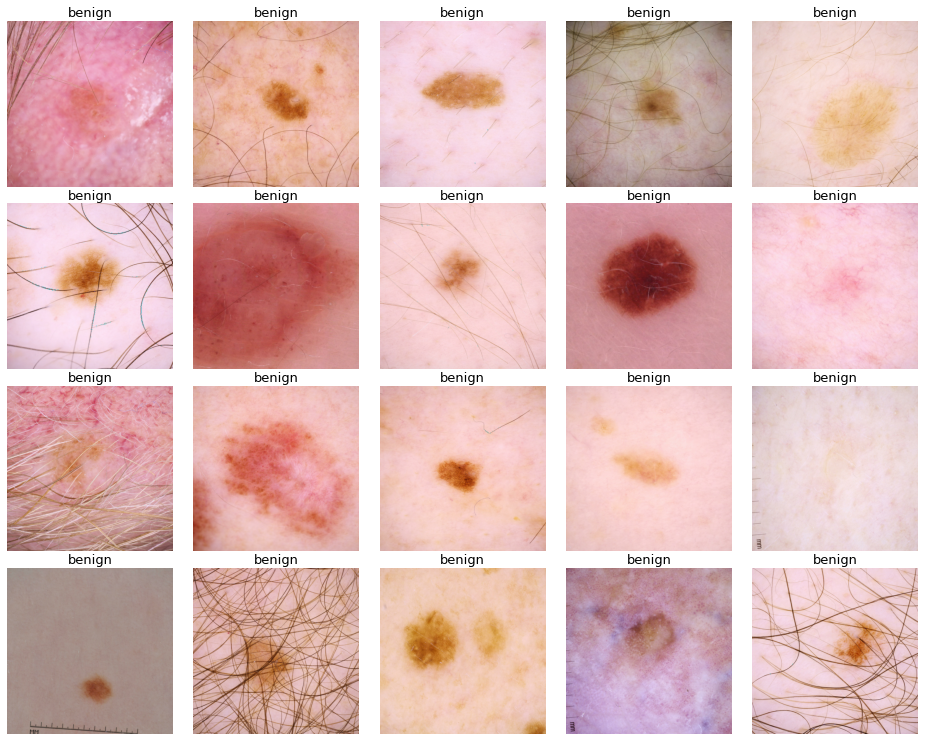

39645

In [15]:
training_dataset = training_dataset.batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))

del training_dataset, train_batch
gc.collect()

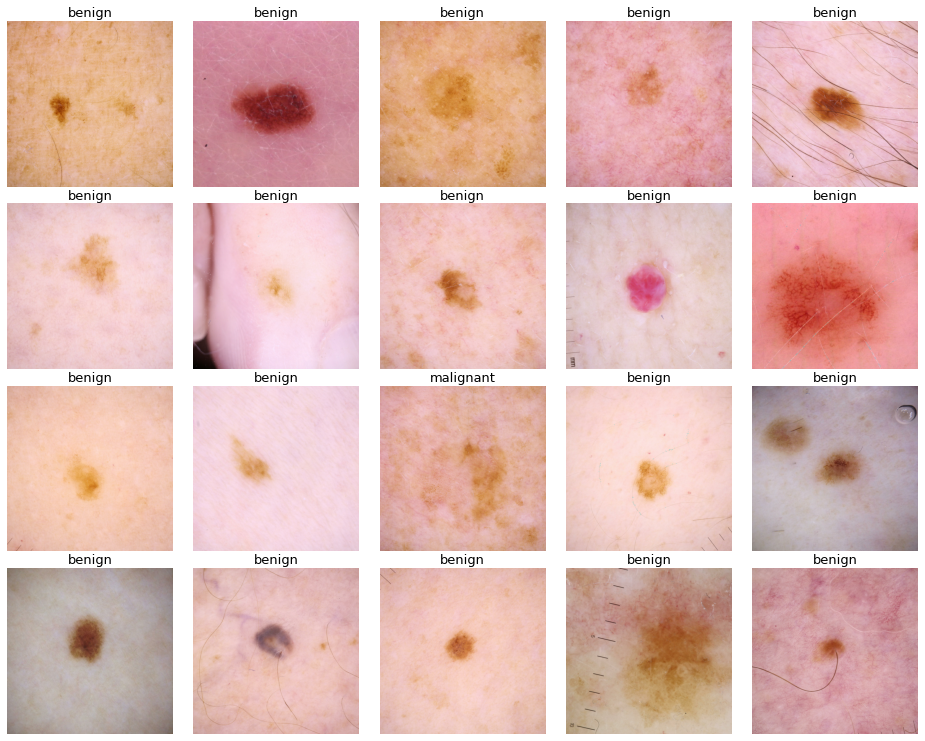

39639

In [16]:
validation_dataset = validation_dataset.batch(20)
validation_batch = iter(validation_dataset)
display_batch_of_images(next(validation_batch))

del validation_dataset, validation_batch
gc.collect()

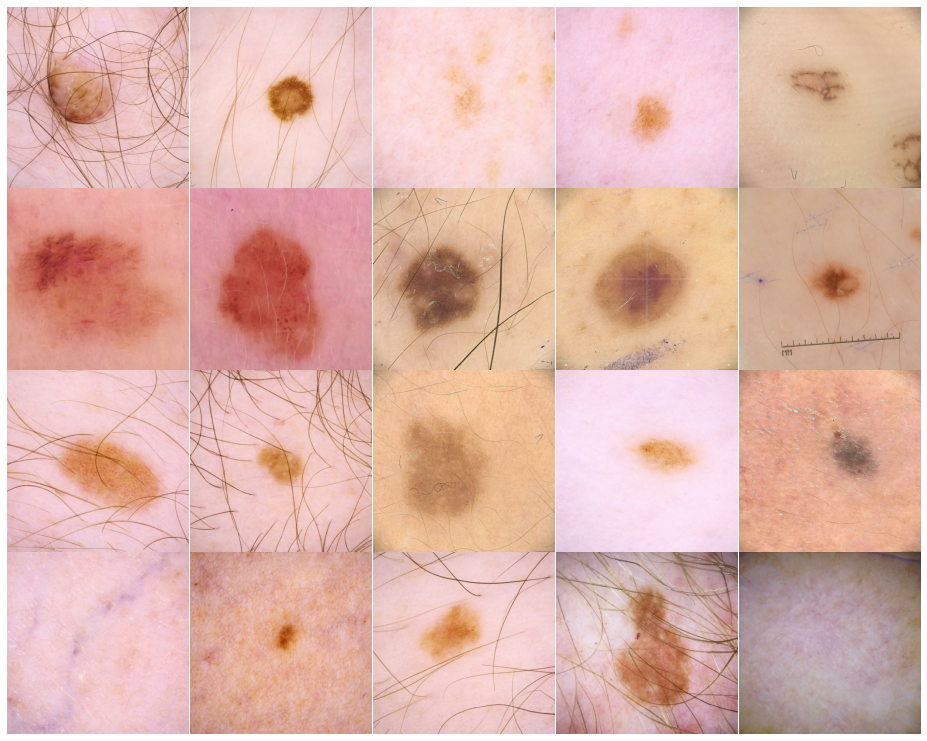

43019

In [17]:
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)
display_batch_of_images(next(test_batch))

del test_dataset, test_batch
gc.collect()

## CREATING MODEL AND CALLBACKS

In [18]:
tab_feats=['age_scaled',
           'sex_female', 
           'sex_male', 
           'sex_unknown', 
           'site_head/neck', 
           'site_lower extremity', 
           'site_oral/genital',
           'site_palms/soles',
           'site_torso',
           'site_unknown',
           'site_upper extremity',
          ]
N_TAB_FEATS=len(tab_feats)
print(f"The number of tabular features is {N_TAB_FEATS}.")

The number of tabular features is 11.


In [19]:
def get_model():
    with strategy.scope():
        pretrained_model = efn.EfficientNetB7(input_shape=(*IMAGE_SIZE, 3),
                                              weights='noisy-student',
                                              include_top=False
                                             )
        pretrained_model.trainable = True
        inp1 = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name='inp1')
        inp2 = tf.keras.layers.Input(shape=(N_TAB_FEATS), name='inp2')
        
        x=pretrained_model(inp1)
        x=tf.keras.layers.GlobalAveragePooling2D()(x)
        x=tf.keras.layers.Dense(512, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(256, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(128, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        y=tf.keras.layers.Dense(100, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(inp2)
        
        concat=tf.keras.layers.concatenate([y, x])
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(concat)
        model = tf.keras.models.Model(inputs=[inp1,inp2], outputs=[output])
    
        model.compile(optimizer='adam',
                      loss = 'binary_crossentropy', 
                      metrics=[tf.keras.metrics.AUC()])
        
        return model
    
model=get_model()
model.summary()

258072576/258068648 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b7 (Model)         (None, 16, 16, 2560) 64097680    inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2560)         0           efficientnet-b7[1][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1311232     global_average_pooling2d[0][0]   
___________________________

In [20]:
del model
gc.collect()

1394

Learning rate schedule: 5e-06 to 5.8e-05 to 6.86e-06


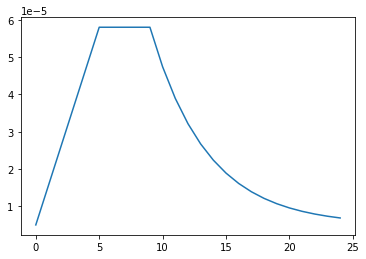

In [21]:
LR_START = 0.000005   #0.00001
LR_MAX = 0.00000725 * strategy.num_replicas_in_sync
LR_MIN = 0.000005
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [22]:
train['target'].values
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train['target'].values),
                                                  y=train['target'].values)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 0.5089730194825149, 1: 28.361301369863014}


In [23]:
class save_best_n(tf.keras.callbacks.Callback):
    def __init__(self, fn, model):
        self.fn = fn
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if (epoch>0):
            score=logs.get("val_auc")
        else:
            score=-1
        if (score > best_score[fold_num].min()):
            idx_min=np.argmin(best_score[fold_num])
            best_score[fold_num][idx_min]=score
            best_epoch[fold_num][idx_min]=epoch+1
            path_best_model=f'best_model_fold_{self.fn}_{idx_min}.hdf5'
            self.model.save(SAVE_FOLDER/path_best_model)

In [24]:
def setup_input(image, label, data, label_name):
    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular=tf.stack(tab_data)
    return {'inp1': image, 'inp2':  tabular}, label

## TRAINING

In [25]:
# chage this for fold number
start_train = 5
# remove break also

In [26]:
%%time

debug=0 
histories = []
best_epoch={fn: np.zeros(NBEST) for fn in range(1, NFOLDS+1)}
best_score={fn: np.zeros(NBEST) for fn in range(1, NFOLDS+1)}

for fold_num in range(start_train, NFOLDS+1):
    
    tf.keras.backend.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    print("="*50)
    print(f"Starting fold {fold_num} out of {NFOLDS}...")
    
    files_trn=TRAIN_FNAMES[f"fold_{fold_num}"]
    files_val=VAL_FNAMES[f"fold_{fold_num}"]
    
    if debug:
        files_trn=files_trn[0:2]
        files_val=files_val[0:2]
        EPOCHS=3
       
    train_dataset = load_dataset(files_trn)
    train_dataset = train_dataset.map(setup_input, num_parallel_calls=AUTO)
    val_dataset = load_dataset(files_val, ordered = True)
    val_dataset = val_dataset.map(setup_input, num_parallel_calls=AUTO)
    
    model = get_model()
    STEPS_PER_EPOCH = count_data_items(files_trn) // BATCH_SIZE
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    history = model.fit(get_training_dataset(train_dataset), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        callbacks=[lr_callback, save_best_n(fold_num, model)],
                        validation_data=get_validation_dataset(val_dataset),
                        class_weight=class_weights,
                        verbose=1,
                       )
    
    idx_sorted=np.argsort(best_score[fold_num])
    best_score[fold_num]=np.array(best_score[fold_num])[idx_sorted]
    best_epoch[fold_num]=np.array(best_epoch[fold_num])[idx_sorted]
    print(f"\nFold {fold_num} is finished. The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}")
    print(f"The corresponding scores: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}")
    print()
    histories.append(history)
    break

Starting fold 5 out of 5...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/25
207/207 [==============================] - 248s 1s/step - loss: 15.1292 - auc: 0.5190 - val_loss: 14.8547 - val_auc: 0.5479 - lr: 5.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1.56e-05.
Epoch 2/25
207/207 [==============================] - 221s 1s/step - loss: 14.0732 - auc: 0.5685 - val_loss: 13.3224 - val_auc: 0.6052 - lr: 1.5600e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.62e-05.
Epoch 3/25
207/207 [==============================] - 221s 1s/step - loss: 12.1452 - auc: 0.6346 - val_loss: 11.0381 - val_auc: 0.7380 - lr: 2.6200e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.68e-05.
Epoch 4/25
207/207 [==============================] - 221s 1s/step - loss: 9.6777 - auc: 0.7440 - val_loss: 8.6095 - val_auc: 0.8057 - lr: 3.6800e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.74e-05.
Epoch 5/2

## TRAINING CURVES

In [27]:
start=5
# put same as start ake start to 0 for full train
NFOLDS=5
# SAVE_FOLDER='../input/me7v4models'   

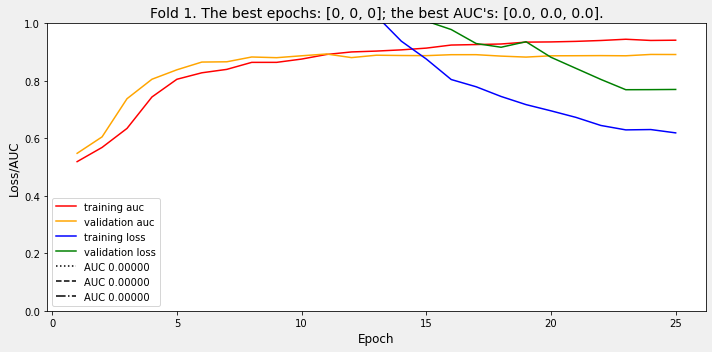

IndexError: list index out of range

In [28]:
def display_training_curves(fold_num, data):

    plt.figure(figsize=(10,5), facecolor='#F0F0F0')
    epochs=np.arange(1, EPOCHS+1)
    plt.plot(epochs, data['auc'], label='training auc', color='red')
    plt.plot(epochs, data['val_auc'], label='validation auc', color='orange')
    plt.plot(epochs, data['loss'], label='training loss', color='blue')    
    plt.plot(epochs, data['val_loss'], label='validation loss', color='green')
    ls=['dotted', 'dashed', 'dashdot', 'solid']                                           
    for i in range(NBEST):
        plt.axvline(best_epoch[fold_num][i], 0, 
                    best_score[fold_num][i], linestyle=ls[i], 
                    color='black', label=f'AUC {best_score[fold_num][i]:.5f}')
    plt.title(f"Fold {fold_num}. The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}; the best AUC's: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}.", 
              fontsize='14')
    plt.ylabel('Loss/AUC', fontsize='12')
    plt.xlabel('Epoch', fontsize='12')
    plt.ylim((0, 1))
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

for fn in range(1, NFOLDS+1):
    display_training_curves(fn, data=histories[fn-1].history)

## PREDICTIONS

In [29]:
def setup_test_image(image, data):    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular=tf.stack(tab_data)
    return {'inp1': image, 'inp2': tabular}

def setup_test_name(image, data):
    return data['image_name']

def get_test_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def average_predictions(X, fn):
    y_probas=[]
    for idx in range(NBEST):
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        gc.collect()
        print(f"Predicting: fold {fn}, model {idx+1} out of {NBEST}...")
        with strategy.scope():
            path_best_model=f'best_model_fold_{fn}_{idx}.hdf5'
            model=tf.keras.models.load_model(os.path.join(SAVE_FOLDER,path_best_model))
        print('Predicting')
        y=model.predict(X, verbose=1)
        y = rankdata(y)/len(y)
        y_probas.append(y)
    y_probas=np.average(y_probas, axis=0)
    return y_probas

if colab:
    OUT_FOLDER=SAVE_FOLDER
else:
    OUT_FOLDER=Path('')

In [30]:
%%time

preds = pd.DataFrame({'image_name': np.zeros(len(test)), 'target': np.zeros(len(test))})
test_ds = load_dataset(TEST_FNAMES, labeled=False, ordered=True)
test_images_ds = test_ds.map(setup_test_image, num_parallel_calls=AUTO)
test_images_ds = get_test_dataset(test_images_ds)
test_ds = get_test_dataset(test_ds)
test_ids_ds = test_ds.map(setup_test_name, num_parallel_calls=AUTO).unbatch()
preds['image_name'] = next(iter(test_ids_ds.batch(N_TEST_IMGS))).numpy().astype('U')
predictions_list = [average_predictions(test_images_ds, fn) for fn in range(start, NFOLDS+1)]

Predicting: fold 5, model 1 out of 3...
Predicting
86/86 [==============================] - 30s 353ms/step
Predicting: fold 5, model 2 out of 3...
Predicting
86/86 [==============================] - 30s 353ms/step
Predicting: fold 5, model 3 out of 3...
Predicting
86/86 [==============================] - 30s 354ms/step
CPU times: user 5min 32s, sys: 1min 15s, total: 6min 47s
Wall time: 10min 23s


In [31]:
for fold_n in range(start, NFOLDS+1):
    del sub['target']
    preds['target'] = predictions_list[NFOLDS-fold_n]
    sub = sub.merge(preds, on='image_name')
    sub.to_csv(OUT_FOLDER/f'submission_ME7_v2_fold{fold_n}.csv', index=False)
    print(sub.head)
del sub['target']
preds['target'] = np.average(predictions_list, axis = 0)
sub = sub.merge(preds, on='image_name')
print(sub.head)
sub.to_csv(OUT_FOLDER/f'submission_ME7_v2_combined.csv', index=False)

<bound method NDFrame.head of          image_name    target
0      ISIC_0052060  0.572239
1      ISIC_0052349  0.057093
2      ISIC_0058510  0.110180
3      ISIC_0073313  0.093577
4      ISIC_0073502  0.566806
...             ...       ...
10977  ISIC_9992485  0.561434
10978  ISIC_9996992  0.818703
10979  ISIC_9997917  0.906817
10980  ISIC_9998234  0.373793
10981  ISIC_9999302  0.526164

[10982 rows x 2 columns]>
<bound method NDFrame.head of          image_name    target
0      ISIC_0052060  0.572239
1      ISIC_0052349  0.057093
2      ISIC_0058510  0.110180
3      ISIC_0073313  0.093577
4      ISIC_0073502  0.566806
...             ...       ...
10977  ISIC_9992485  0.561434
10978  ISIC_9996992  0.818703
10979  ISIC_9997917  0.906817
10980  ISIC_9998234  0.373793
10981  ISIC_9999302  0.526164

[10982 rows x 2 columns]>
